# The e2e Model Lifecycle on SAS Viya Platform

In this notebook, 

1. Build and train the model.
2. Create an API of the model. (Here we have put it in a flask API).
3. Create the requirements file containing all the required libraries.
4. Create the docker file with necessary environment setup and start-up operations.
5. Build the docker image.

I train XGboost model for testing Docker Private ML environment

## Libraries

In [1]:
# Mongo Library

import pymongo

# ML libraries 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
from xgboost import XGBClassifier 

# Tool libraries

# import json
import os
import pprint
# import requests as req
# import random
# import pickle
# import zipfile
# import urllib
# import base64
# import time
# import sys

# import sasctl

## Data Engineering

### Load Data from Mongo

In [2]:
#Connect to mongodb container

conn = pymongo.MongoClient('mongo', 27017)

In [3]:
conn

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

In [4]:
db = conn.training
collection = db.churn_data

In [5]:
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3667,1,9,
1,1,1300,70053,68400,HomeImp,Other,7,0,2,121.833,0,14,
2,1,1500,13500,16700,HomeImp,Other,4,0,0,149.467,1,10,
3,1,1500,,,,,,,,,,,
4,0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333,0,14,


### Declare data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5960 non-null object
VALUE      5960 non-null object
REASON     5960 non-null object
JOB        5960 non-null object
YOJ        5960 non-null object
DEROG      5960 non-null object
DELINQ     5960 non-null object
CLAGE      5960 non-null object
NINQ       5960 non-null object
CLNO       5960 non-null object
DEBTINC    5960 non-null object
dtypes: int64(2), object(11)
memory usage: 651.9+ KB


In [7]:
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [8]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333336,0.0,14.0,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null category
LOAN       5960 non-null int64
MORTDUE    5442 non-null float32
VALUE      5848 non-null float32
REASON     5960 non-null object
JOB        5960 non-null object
YOJ        5445 non-null float32
DEROG      5252 non-null float32
DELINQ     5380 non-null float32
CLAGE      5652 non-null float32
NINQ       5450 non-null float32
CLNO       5738 non-null float32
DEBTINC    4693 non-null float32
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 401.7+ KB


### Declare variables 

In [10]:
#target var
target = df.select_dtypes('category').columns

#categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)

#input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

inputs= class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

Index(['BAD'], dtype='object')
['REASON', 'JOB']
['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [11]:
df[inputs]

,REASON,JOB,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,HomeImp,Other,1100,25860.0,39025.0,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,HomeImp,Other,1300,70053.0,68400.0,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,HomeImp,Other,1500,13500.0,16700.0,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,,,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HomeImp,Office,1700,97800.0,112000.0,3.0,0.0,0.0,93.333336,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,DebtCon,Other,88900,57264.0,90185.0,16.0,0.0,0.0,221.808716,0.0,16.0,36.112347
5956,DebtCon,Other,89000,54576.0,92937.0,16.0,0.0,0.0,208.692062,0.0,15.0,35.859970
5957,DebtCon,Other,89200,54045.0,92924.0,15.0,0.0,0.0,212.279694,0.0,15.0,35.556591
5958,DebtCon,Other,89900,48811.0,88934.0,15.0,0.0,0.0,219.600998,0.0,16.0,34.571518


### Impute missing

In [12]:
categorical_imputer = SimpleImputer(missing_values = '', strategy = 'most_frequent')
numerical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(data=categorical_imputed, columns=class_inputs)
df_categorical_imputed.info()

print('-'*50)

#Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(data=numerical_imputed, columns=numerical_inputs)
df_numerical_imputed.info()
df_numerical_imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 2 columns):
REASON    5960 non-null object
JOB       5960 non-null object
dtypes: object(2)
memory usage: 93.2+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 10 columns):
LOAN       5960 non-null float64
MORTDUE    5960 non-null float64
VALUE      5960 non-null float64
YOJ        5960 non-null float64
DEROG      5960 non-null float64
DELINQ     5960 non-null float64
CLAGE      5960 non-null float64
NINQ       5960 non-null float64
CLNO       5960 non-null float64
DEBTINC    5960 non-null float64
dtypes: float64(10)
memory usage: 465.8 KB


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915
1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915
2,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915
3,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...
5955,88900.0,57264.000000,90185.000000,16.000000,0.00000,0.000000,221.808716,0.000000,16.000000,36.112347
5956,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970
5957,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591
5958,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518


### One-Hot encoding for categorical variables

In [13]:
encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
categories

# print(categorical_encoded.toarray())
df_categorical_encoded = pd.DataFrame(data=categorical_encoded.toarray(), columns=categories)
df_categorical_encoded.info()
df_categorical_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 8 columns):
DebtCon    5960 non-null float64
HomeImp    5960 non-null float64
Mgr        5960 non-null float64
Office     5960 non-null float64
Other      5960 non-null float64
ProfExe    5960 non-null float64
Sales      5960 non-null float64
Self       5960 non-null float64
dtypes: float64(8)
memory usage: 372.6 KB


,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5955,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### ABT

In [14]:
abt = pd.concat([df[target], df_numerical_imputed, df_categorical_encoded], axis=1)
abt


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,1,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900.0,57264.000000,90185.000000,16.000000,0.00000,0.000000,221.808716,0.000000,16.000000,36.112347,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,0,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,0,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,0,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
abt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 19 columns):
BAD        5960 non-null category
LOAN       5960 non-null float64
MORTDUE    5960 non-null float64
VALUE      5960 non-null float64
YOJ        5960 non-null float64
DEROG      5960 non-null float64
DELINQ     5960 non-null float64
CLAGE      5960 non-null float64
NINQ       5960 non-null float64
CLNO       5960 non-null float64
DEBTINC    5960 non-null float64
DebtCon    5960 non-null float64
HomeImp    5960 non-null float64
Mgr        5960 non-null float64
Office     5960 non-null float64
Other      5960 non-null float64
ProfExe    5960 non-null float64
Sales      5960 non-null float64
Self       5960 non-null float64
dtypes: category(1), float64(18)
memory usage: 890.6 KB


## Model Development

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)], 
                                                                    abt[target], 
                                                                    test_size=0.33, random_state=27513)

## Look at traditional models...

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    ]

labels = ['Logit', 'DTree', 'RFor', 'GBoost']

In [18]:
models = []
models_dic = {}

for label, classifier in zip(labels, classifiers):
    model = classifier.fit(X_train, y_train.values.ravel())
    models_dic = {'label': label, 'model': model}
    models.append(models_dic)

pprint.pprint(models)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[{'label': 'Logit',
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)},
 {'label': 'DTree',
  'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')},
 {'label': 'RFor',
  'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                 

In [19]:
print('Misclassification Rates')
for m in models:
    dt_misclassification = 1 - metrics.accuracy_score(y_test, m['model'].predict(X_test))
    print('{} :'.format(m['label']), dt_misclassification)

Misclassification Rates
Logit : 0.1906456532791052
DTree : 0.11947127605490593
RFor : 0.09150991357397054
GBoost : 0.09303507880020334


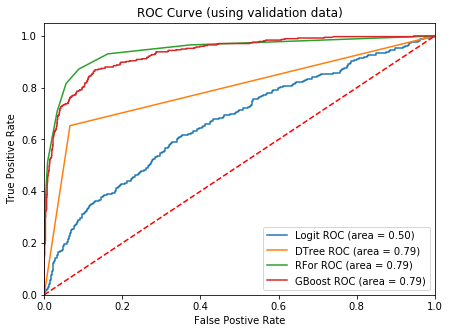

In [20]:
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

In [21]:
del_models = ['Logit', 'DTree']

for model_dict in models:
    if model_dict['label'] in del_models:
        models.remove(model_dict)

## Model Assessment

In [22]:
%%time

xgb = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=100,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.13348	validation_0-logloss:0.63315	validation_1-error:0.12710	validation_1-logloss:0.63165
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.13148	validation_0-logloss:0.58412	validation_1-error:0.12557	validation_1-logloss:0.58201
[2]	validation_0-error:0.12272	validation_0-logloss:0.54814	validation_1-error:0.11846	validation_1-logloss:0.54655
[3]	validation_0-error:0.12171	validation_0-logloss:0.51239	validation_1-error:0.11744	validation_1-logloss:0.51060
[4]	validation_0-error:0.12196	validation_0-logloss:0.48268	validation_1-error:0.12252	validation_1-logloss:0.48163
[5]	validation_0-error:0.11746	validation_0-logloss:0.46025	validation_1-error:0.11846	validation_1-logloss:0.46049
[6]	validation_0-error:0.11796	validation_0-logloss:0.44048	validation_1-error:0.11591	validation_1-logloss:0.44144
[7]	validation_0-error:

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[16]	validation_0-error:0.10594	validation_0-logloss:0.31561	validation_1-error:0.10829	validation_1-logloss:0.32539
[17]	validation_0-error:0.10468	validation_0-logloss:0.30980	validation_1-error:0.10778	validation_1-logloss:0.32087
[18]	validation_0-error:0.10218	validation_0-logloss:0.30301	validation_1-error:0.10778	validation_1-logloss:0.31499
[19]	validation_0-error:0.10343	validation_0-logloss:0.29767	validation_1-error:0.10524	validation_1-logloss:0.31094
[20]	validation_0-error:0.10268	validation_0-logloss:0.29250	validation_1-error:0.10320	validation_1-logloss:0.30653
[21]	validation_0-error:0.10093	validation_0-logloss:0.28856	validation_1-error:0.10473	validation_1-logloss:0.30377
[22]	validation_0-error:0.10018	validation_0-logloss:0.28377	validation_1-error:0.10676	validation_1-logloss:0.30027
[23]	validation_0-error:0.09942	validation_0-logloss:0.27924	validation_1-error:0.10422	validation_1-logloss:0.29623
[24]	validation_0-error:0.09967	validation_0-logloss:0.27559	val

[87]	validation_0-error:0.06536	validation_0-logloss:0.18043	validation_1-error:0.09304	validation_1-logloss:0.23077
[88]	validation_0-error:0.06637	validation_0-logloss:0.17935	validation_1-error:0.09456	validation_1-logloss:0.23019
[89]	validation_0-error:0.06662	validation_0-logloss:0.17824	validation_1-error:0.09456	validation_1-logloss:0.22971
[90]	validation_0-error:0.06587	validation_0-logloss:0.17752	validation_1-error:0.09253	validation_1-logloss:0.22931
[91]	validation_0-error:0.06637	validation_0-logloss:0.17706	validation_1-error:0.09304	validation_1-logloss:0.22923
[92]	validation_0-error:0.06511	validation_0-logloss:0.17611	validation_1-error:0.09253	validation_1-logloss:0.22844
[93]	validation_0-error:0.06511	validation_0-logloss:0.17508	validation_1-error:0.09253	validation_1-logloss:0.22749
[94]	validation_0-error:0.06336	validation_0-logloss:0.17377	validation_1-error:0.09253	validation_1-logloss:0.22740
[95]	validation_0-error:0.06361	validation_0-logloss:0.17334	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='auto', validate_parameters=False, verbosity=1)

In [23]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, xgb.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification)

Misclassification Rates
 XGBoost : 0.09354346720894768


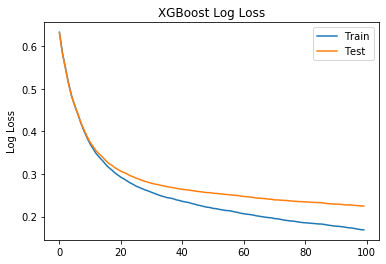

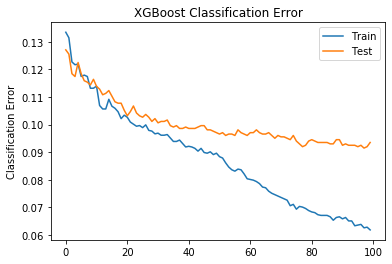

In [24]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


In [25]:
models.append({'label': 'XGBoost','model': xgb})

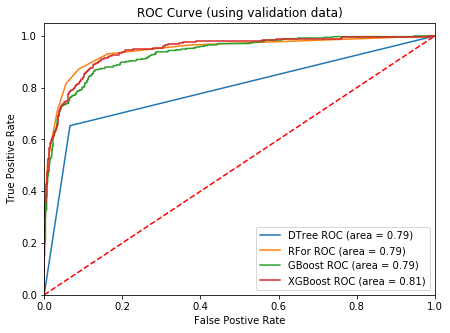

In [26]:
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

#### The champion model is Rfor. And the challenger is Gboost

## Machine Learning Engineering

### Create ML pipelines

# Rfor pipeline

In [27]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

rfor_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())

])

## Gboost pipeline

In [28]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

gboost_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())

])

## Test fit and predict

In [29]:
Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(df[df.columns.difference(target)], 
                                                                    df[target], 
                                                                    test_size=0.33, random_state=27513)

In [30]:
rfor_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=rfor_pipeline.predict(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([1, 0, 1, ..., 0, 0, 0])

In [31]:
rfor_pipeline.score(Prod_X_test, Prod_y_test)

0.9084900864260295

In [32]:
gboost_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=gboost_pipeline.predict(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 0, 0, 0])

In [33]:
gboost_pipeline.score(Prod_X_test, Prod_y_test)

0.9084900864260295

# Model Deployment

For Model Deployment purpose, we need some files:

    0. requirement.txt    
    1. score.py
    2. model.pickle
    3. dmcas_fitstat.json
    4. inputVar.json
    5. outputVar.json
    6. fileMetadata.json
    7. ModelProperties.json


In [ ]:
! mkdir experiment_rfor experiment_gboost

## 1. requirement.txt

In [ ]:
! pip freeze > ./experiment_rfor/requirement.txt
! pip freeze > ./experiment_gboost/requirement.txt

## 2. Score.py 

## 3. model.pkl

In [34]:
from sklearn.externals import joblib
folders = ['experiment_rfor', 'experiment_gboost']
pipes = [rfor_pipeline, gboost_pipeline]
pickles = ['rfor_pipeline.pkl', 'gboost_pipeline.pkl']

for folder, pipe, pkl in zip(folders, pipes, pickles):
    joblib.dump(pipe, './{}/{}'.format(folder, pkl))

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [35]:
from viya_services import modelmanager_service

## 4. inputVar

In [36]:
for folder in folders: 
    modelmanager_service.generate_inputvar(abt, 'BAD', './{}'.format(folder), debug=False)

## 5. outputVar and targetVar

In [37]:
for folder in folders:
    modelmanager_service.generate_outputvar(abt, 'BAD', './{}'.format(folder))